# Setting up Dataset and Helper Functions

## Checking GPU Type

In [ ]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-d7cf2baa-17c0-504e-512f-534c17ed229d)


## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Since mixed precision training was introduced in TensorFlow 2.4.0, make sure you've got at least TensorFlow 2.4.0+.

In [ ]:
!pip install numpy==1.23.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 74.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


In [ ]:
# Note: As of May 2023, there have been some issues with TensorFlow versions 2.9-2.12
# with the following code.
# However, these seemed to have been fixed in version 2.13+.
# TensorFlow version 2.13 is available in tf-nightly as of May 2023 (will be default in Google Colab soon).
# Therefore, to prevent errors we'll install tf-nightly first.
# See more here: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/550

# Install tf-nightly (required until 2.13.0+ is the default in Google Colab)
!pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.8 MB/s eta 0:00:00


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


TensorFlow version: 2.14.0-dev20230718
Notebook last run (end-to-end): 2023-07-19 03:50:27.505638


## Get helper functions

We've created a series of helper functions throughout the previous notebooks in the course. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [ ]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-07-19 03:50:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-19 03:50:36 (115 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after (`"food101"`) is present.

In [ ]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [ ]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
len(train_data), len(test_data)

(75750, 25250)

In [ ]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 75
  Class name (str form): pho
        


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [ ]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 48,  51,  30],
        [ 49,  52,  31],
        [ 50,  55,  33],
        ...,
        [ 93, 120,  77],
        [ 87, 112,  70],
        [ 80, 105,  63]],

       [[ 43,  46,  25],
        [ 46,  49,  28],
        [ 49,  54,  32],
        ...,
        [ 95, 122,  77],
        [ 90, 117,  72],
        [ 83, 110,  65]],

       [[ 40,  43,  22],
        [ 45,  48,  27],
        [ 50,  55,  33],
        ...,
        [ 90, 119,  71],
        [ 87, 116,  68],
        [ 84, 113,  65]],

       ...,

       [[ 48,  55,  37],
        [ 48,  55,  37],
        [ 41,  50,  33],
        ...,
        [ 32,  43,  35],
        [ 25,  36,  30],
        [ 21,  32,  26]],

       [[ 42,  47,  27],
        [ 38,  46,  25],
        [ 34,  43,  26],
        ...,
        [ 38,  49,  41],
        [ 33,  44,  38],
        [ 29,  40,  34]],

       [[ 37,  42,  20],
        [ 32,  40,  19],
        [ 31,  38,  20],
        ...,
        [ 33,  44,  3

In [ ]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

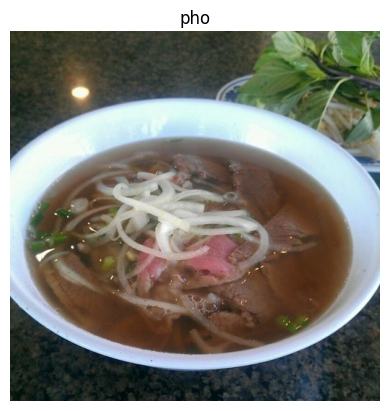

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

Delicious!

Okay, looks like the Food101 data we've got from TFDS is similar to the datasets we've been using in previous notebooks.

Now let's preprocess it and get it ready for use with a neural network.

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 48  51  30]
  [ 49  52  31]
  [ 50  55  33]
  ...
  [ 93 120  77]
  [ 87 112  70]
  [ 80 105  63]]

 [[ 43  46  25]
  [ 46  49  28]
  [ 49  54  32]
  ...
  [ 95 122  77]
  [ 90 117  72]
  [ 83 110  65]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 46.2551    49.2551    28.255102]
  [ 49.954082  54.954082  32.954082]
  [ 42.494896  50.494896  27.494898]
  ...
  [ 97.50995  129.86195   81.4385  ]
  [ 94.02041  122.21427   77.33163 ]
  [ 86.42833  112.71404   68.78547 ]]

 [[ 45.336735  48.336735  27.336735]
  [ 53.714287  58.714287  36.714287]
  [ 40.44388   48.44388   25.443878]
  ...
  [ 92.948906 128.3213    74.52029 ]
  [ 85.48981  117.27552   67.41838 ]
  [ 90.70417  122.48989   72.632744]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


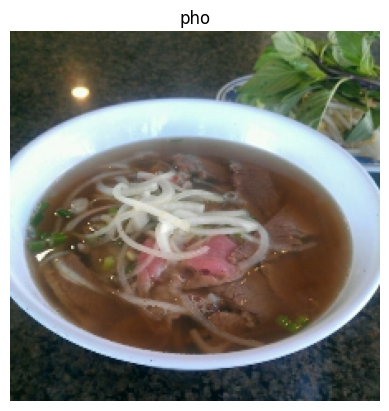

In [ ]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

And now let's check out what our prepared datasets look like.

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [ ]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

Great, since the global dtype policy is now `"mixed_float16"` our model will automatically take advantage of float16 variables where possible and in turn speed up training.

## Setting up Modelling Callbacks

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training.

Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 5 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# Building Models Using Transfer Learning

## Base Model - VGG19

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.VGG19(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.Rescaling(1./255)(x)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Check out our model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 rescaling_3 (Rescaling)     (None, 7, 7, 512)         0         
                                                                 
 pooling_layer (GlobalAverag  (None, 512)              0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               51813     
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                         

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
vgg19 False float32 <Policy "mixed_float16">
rescaling_1 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
block1_conv1 False float32 <Policy "mixed_float16">
block1_conv2 False float32 <Policy "mixed_float16">
block1_pool False float32 <Policy "mixed_float16">
block2_conv1 False float32 <Policy "mixed_float16">
block2_conv2 False float32 <Policy "mixed_float16">
block2_pool False float32 <Policy "mixed_float16">
block3_conv1 False float32 <Policy "mixed_float16">
block3_conv2 False float32 <Policy "mixed_float16">
block3_conv3 False float32 <Policy "mixed_float16">
block3_conv4 False float32 <Policy "mixed_float16">
block3_pool False float32 <Policy "mixed_float16">
block4_conv1 False float32 <Policy "mixed_float16">
block4_conv2 False float32 <Policy "mixed_float16">
block4_conv3 False float32 <Policy "mixed_float16">
block4_conv4 False float32 <Policy "mixed_float16">
block4_pool False float32 <Policy "mixed_float16">
block5_conv1 False float32 <Policy "mixed_float16">
block5_conv2 False float32 <Policy "mixed_float16">
block5_conv3 False float32 

> 🔑 **Note:** The mixed precision API automatically causes layers which can benefit from using the `"mixed_float16"` dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

### Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_vgg19 = model.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=int(0.15 * len(test_data)),
                          callbacks=[create_tensorboard_callback("training_logs",
                          "vgg19_feature_extract"),
                          model_checkpoint])

Saving TensorBoard log files to: training_logs/vgg19_feature_extract/20230717-104122
Epoch 1/5
2368/2368 [==============================] - 95s 39ms/step - loss: 4.3740 - accuracy: 0.1821 - val_loss: 4.1230 - val_accuracy: 0.3318
Epoch 2/5
2368/2368 [==============================] - 94s 39ms/step - loss: 3.9849 - accuracy: 0.2901 - val_loss: 3.7678 - val_accuracy: 0.3432
Epoch 3/5
2368/2368 [==============================] - 87s 36ms/step - loss: 3.7011 - accuracy: 0.3158 - val_loss: 3.5015 - val_accuracy: 0.3586
Epoch 4/5
2368/2368 [==============================] - 87s 36ms/step - loss: 3.4860 - accuracy: 0.3344 - val_loss: 3.3041 - val_accuracy: 0.3779
Epoch 5/5
2368/2368 [==============================] - 86s 36ms/step - loss: 3.3184 - accuracy: 0.3496 - val_loss: 3.1450 - val_accuracy: 0.3872


Nice, looks like our feature extraction model is performing pretty well. How about we evaluate it on the whole test dataset?

In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_vgg19 = model.evaluate(test_data)
results_feature_extract_vgg19

790/790 [==============================] - 25s 32ms/step - loss: 3.1676 - accuracy: 0.3794


[3.1675586700439453, 0.37936633825302124]

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
block1_conv1 False float32 <Policy "mixed_float16">
block1_conv2 False float32 <Policy "mixed_float16">
block1_pool False float32 <Policy "mixed_float16">
block2_conv1 False float32 <Policy "mixed_float16">
block2_conv2 False float32 <Policy "mixed_float16">
block2_pool False float32 <Policy "mixed_float16">
block3_conv1 False float32 <Policy "mixed_float16">
block3_conv2 False float32 <Policy "mixed_float16">
block3_conv3 False float32 <Policy "mixed_float16">
block3_conv4 False float32 <Policy "mixed_float16">
block3_pool False float32 <Policy "mixed_float16">
block4_conv1 False float32 <Policy "mixed_float16">
block4_conv2 False float32 <Policy "mixed_float16">
block4_conv3 False float32 <Policy "mixed_float16">
block4_conv4 False float32 <Policy "mixed_float16">
block4_pool False float32 <Policy "mixed_float16">
block5_conv1 False float32 <Policy "mixed_float16">
block5_conv2 False float32 <Policy "mixed_float16">
block5_conv3 False float32 

### Save Feature Extraction Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_vgg19_feature_extraction.hdf5")

And again, we can check whether or not our model saved correctly by loading it in and evaluating it.

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model("/content/drive/My Drive/Food Vision/food_vision_vgg19_feature_extraction.hdf5")

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 27s 34ms/step - loss: 3.1676 - accuracy: 0.3794


[3.16756010055542, 0.37936633825302124]

### Preparing our model's layers for fine-tuning

Great, our loaded model is performing as expected.

When we first created our model, we froze all of the layers in the base model by setting `base_model.trainable=False` but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [ ]:
# Are any of the layers in our model frozen?
for layer in model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
vgg19 True float32 <Policy "mixed_float16">
rescaling_3 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Alright, it seems like each layer in our loaded model is trainable. But what if we got a little deeper and inspected each of the layers in our base model?

> 🤔 **Question:** *Which layer in the loaded model is our base model?*

Before saving the Functional model to file, we created it with five layers (layers below are 0-indexed):
0. The input layer
1. The pre-trained base model layer ([`tf.keras.applications.efficientnet.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0))
2. The pooling layer
3. The fully-connected (dense) layer
4. The output softmax activation (with float32 dtype)

Therefore to inspect our base model layer, we can access the `layers` attribute of the layer at index 1 in our model.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 True float32 <Policy "float32">
block1_conv1 True float32 <Policy "mixed_float16">
block1_conv2 True float32 <Policy "mixed_float16">
block1_pool True float32 <Policy "mixed_float16">
block2_conv1 True float32 <Policy "mixed_float16">
block2_conv2 True float32 <Policy "mixed_float16">
block2_pool True float32 <Policy "mixed_float16">
block3_conv1 True float32 <Policy "mixed_float16">
block3_conv2 True float32 <Policy "mixed_float16">
block3_conv3 True float32 <Policy "mixed_float16">
block3_conv4 True float32 <Policy "mixed_float16">
block3_pool True float32 <Policy "mixed_float16">
block4_conv1 True float32 <Policy "mixed_float16">
block4_conv2 True float32 <Policy "mixed_float16">
block4_conv3 True float32 <Policy "mixed_float16">
block4_conv4 True float32 <Policy "mixed_float16">
block4_pool True float32 <Policy "mixed_float16">
block5_conv1 True float32 <Policy "mixed_float16">
block5_conv2 True float32 <Policy "mixed_float16">
block5_conv3 True float32 <Policy "mixed_float

Wonderful, it looks like each layer in our base model is trainable (unfrozen) and every layer which should be using the dtype policy `"mixed_policy16"` is using it.

Since we've got so much data (750 images x 101 training classes = 75750 training images), let's keep all of our base model's layers unfrozen.

> 🔑 **Note:** If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

Okay, model compiled.

Now let's fit it on all of the data.

We'll set it up to run for up to 100 epochs.

Since we're going to be using the `EarlyStopping` callback, it might stop before reaching 100 epochs.

> 🔑 **Note:** Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so with **unoptimized** data pipelines and **without** mixed precision training will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs). But don't worry, **the code we've written above will ensure it runs much faster** (more like 4-5 minutes per epoch).

### Fit the fine tuning model

In [ ]:
# Start to fine-tune (all layers)
history_vgg19_fine_tuning = model.fit(train_data,
                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                      callbacks=[create_tensorboard_callback("training_logs", "vgg19_fine_tuning"), # track the model training logs
                                      model_checkpoint, # save only the best model during training
                                      early_stopping, # stop model after X epochs of no improvements
                                      reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/vgg19_fine_tuning/20230717-105233
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 2.3515 - accuracy: 0.4325

2368/2368 [==============================] - 224s 91ms/step - loss: 2.3515 - accuracy: 0.4325 - val_loss: 1.8142 - val_accuracy: 0.5355 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 1.6675 - accuracy: 0.5805

2368/2368 [==============================] - 217s 91ms/step - loss: 1.6674 - accuracy: 0.5805 - val_loss: 1.4149 - val_accuracy: 0.6348 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 1.3230 - accuracy: 0.6552

2368/2368 [==============================] - 218s 91ms/step - loss: 1.3231 - accuracy: 0.6552 - val_loss: 1.2660 - val_accuracy: 0.6576 - lr: 1.0000e-04
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 1.0421 - accuracy: 0.7190

2368/2368 [==============================] - 217s 91ms/step - loss: 1.0423 - accuracy: 0.7190 - val_loss: 1.1715 - val_accuracy: 0.6931 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 212s 89ms/step - loss: 0.7932 - accuracy: 0.7790 - val_loss: 1.2017 - val_accuracy: 0.6899 - lr: 1.0000e-04
Epoch 6/100
2367/2368 [============================>.] - ETA: 0s - loss: 1.1391 - accuracy: 0.8259
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 211s 89ms/step - loss: 1.1391 - accuracy: 0.8259 - val_loss: 1.3110 - val_accuracy: 0.6663 - lr: 1.0000e-04
Epoch 7/100
2368/2368 [==============================] - 209s 88ms/step - loss: 3.8030 - accuracy: 0.9511 - val_loss: 1.2980 - val_accuracy: 0.7447 - lr: 2.0000e-05
Epoch 8/100
2367/2368 [============================>.] - ETA: 0s - loss: 2.0916 - accuracy: 0.9805
Epoch 8: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==

### Save Fine Tuned Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_vgg19_fine_tuned.hdf5")

Now we can load it using the [`tf.keras.models.load_model()`](https://www.tensorflow.org/tutorials/keras/save_and_load) method and get a summary (it should be the exact same as the model we created above).

In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_model = tf.keras.models.load_model("/content/drive/My Drive/Food Vision/food_vision_vgg19_fine_tuned.hdf5")

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 rescaling_3 (Rescaling)     (None, 7, 7, 512)         0         
                                                                 
 pooling_layer (GlobalAverag  (None, 512)              0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               51813     
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                         

Finally, we can evaluate our model on the test data (this requires the `test_data` variable to be loaded.

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_model = loaded_fine_tuned_model.evaluate(test_data)
results_downloaded_fine_tuned_model

790/790 [==============================] - 27s 33ms/step - loss: 2.9397 - accuracy: 0.7457


[2.9397265911102295, 0.7456633448600769]

Excellent! Our saved model is performing as expected (better results than the DeepFood paper!).

Congrautlations! You should be excited! You just trained a computer vision model with competitive performance to a research paper and in far less time (our model took ~20 minutes to train versus DeepFood's quoted 2-3 days).

In other words, you brought Food Vision life!

If you really wanted to step things up, you could try using the [`EfficientNetB4`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB4) model (a larger version of `EfficientNetB0`). At at the time of writing, the EfficientNet family has the [state of the art classification results](https://paperswithcode.com/sota/fine-grained-image-classification-on-food-101) on the Food101 dataset.

> 📖 **Resource:** To see which models are currently performing the best on a given dataset or problem type as well as the latest trending machine learning research, be sure to check out [paperswithcode.com](http://paperswithcode.com/) and [sotabench.com](https://sotabench.com/).

## Base Model - EfficientNetB4

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = data_augmentation(inputs)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1792)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb4 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_2 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Pol

### Fit the feature Extraction Model

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_efficientnetb4 = model.fit(train_data,
                                   epochs=5,
                                   steps_per_epoch=len(train_data),
                                   validation_data=test_data,
                                   validation_steps=int(0.15 * len(test_data)),
                                   callbacks=[create_tensorboard_callback("training_logs",
                                   "efficientnetb4_feature_extract"),
                                    model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb4_feature_extract/20230717-170416
Epoch 1/5
2368/2368 [==============================] - 191s 71ms/step - loss: 1.7894 - accuracy: 0.5569 - val_loss: 1.2643 - val_accuracy: 0.6594
Epoch 2/5
2368/2368 [==============================] - 165s 69ms/step - loss: 1.3085 - accuracy: 0.6582 - val_loss: 1.1508 - val_accuracy: 0.6901
Epoch 3/5
2368/2368 [==============================] - 167s 70ms/step - loss: 1.1625 - accuracy: 0.6937 - val_loss: 1.1294 - val_accuracy: 0.7005
Epoch 4/5
2368/2368 [==============================] - 165s 69ms/step - loss: 1.0635 - accuracy: 0.7181 - val_loss: 1.0925 - val_accuracy: 0.7087
Epoch 5/5
2368/2368 [==============================] - 169s 71ms/step - loss: 0.9891 - accuracy: 0.7362 - val_loss: 1.0890 - val_accuracy: 0.6992


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_efficientnetb4 = model.evaluate(test_data)
results_feature_extract_efficientnetb4

790/790 [==============================] - 31s 39ms/step - loss: 1.0852 - accuracy: 0.7036


[1.0852420330047607, 0.7036435604095459]

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_2 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Pol

### Save Feature Extraction Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_efficientnetb4_feature_extraction.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3078: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model("/content/drive/My Drive/Food Vision/food_vision_efficientnetb4_feature_extraction.hdf5")

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 36s 41ms/step - loss: 1.0852 - accuracy: 0.7036


[1.0852423906326294, 0.7036435604095459]

### Preparing our model's layers for fine-tuning

In [ ]:
# Are any of the layers in our model frozen?
for layer in model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling_1 True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
rescaling_2 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1b_dwconv True float32 <Policy "mixed_float16"

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

### Fit the fine tuning model

In [ ]:
# Start to fine-tune (all layers)
history_efficientnetb4_fine_tuning = model.fit(train_data,
                                               epochs=100, # fine-tune for a maximum of 100 epochs
                                               steps_per_epoch=len(train_data),
                                               validation_data=test_data,
                                               validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                               callbacks=[create_tensorboard_callback("training_logs", "efficientnetb4_fine_tuning"), # track the model training logs
                                               model_checkpoint, # save only the best model during training
                                               early_stopping, # stop model after X epochs of no improvements
                                               reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientnetb4_fine_tuning/20230717-172140
Epoch 1/100
2368/2368 [==============================] - 516s 183ms/step - loss: 0.8366 - accuracy: 0.7711 - val_loss: 0.7251 - val_accuracy: 0.7945 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 365s 154ms/step - loss: 0.3300 - accuracy: 0.9054 - val_loss: 0.7939 - val_accuracy: 0.7908 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9611
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 368s 155ms/step - loss: 0.1268 - accuracy: 0.9611 - val_loss: 0.8372 - val_accuracy: 0.7982 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 372s 157ms/step - loss: 0.0216 - accuracy: 0.9945 - val_loss: 0.8761 - val_accuracy: 0.8247 - lr: 2.0000e-05
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0025 - 

### Save Fine Tuned Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_efficientnetb4_fine_tuned.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3078: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_model = tf.keras.models.load_model("/content/drive/My Drive/Food Vision/food_vision_efficientnetb4_fine_tuned.hdf5")

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1792)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_model = loaded_fine_tuned_model.evaluate(test_data)
results_downloaded_fine_tuned_model

790/790 [==============================] - 37s 41ms/step - loss: 1.2087 - accuracy: 0.8287


[1.208654761314392, 0.828673243522644]

## Base Model - MobileNetV3Large

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV3Large(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
x = layers.Rescaling(1./255)(x)
x = data_augmentation(inputs)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Check out our model
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 pooling_layer (GlobalAvera  (None, 960)               0         
 gePooling2D)                                                    
                                                                 
 dense_7 (Dense)             (None, 101)               97061     
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
MobilenetV3large False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_7 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_8 False float32 <Policy "float32">
rescaling_4 False float32 <Policy "mixed_float16">
Conv False float32 <Policy "mixed_float16">
Conv/BatchNorm False float32 <Policy "mixed_float16">
tf.__operators__.add_28 False float32 <Policy "mixed_float16">
re_lu_39 False float32 <Policy "mixed_float16">
tf.math.multiply_28 False float32 <Policy "mixed_float16">
multiply_20 False float32 <Policy "mixed_float16">
expanded_conv/depthwise False float32 <Policy "mixed_float16">
expanded_conv/depthwise/BatchNorm False float32 <Policy "mixed_float16">
re_lu_40 False float32 <Policy "mixed_float16">
expanded_conv/project False float32 <Policy "mixed_float16">
expanded_conv/project/BatchNorm False float32 <Policy "mixed_float16">
expanded_conv/Add False float32 <Policy "mixed_float16">
expanded_conv_1/expand False float32 <Policy "mixed_float16">
expanded_conv_1/expand/BatchNorm False float32 <Policy "mixed_float16">
re_lu_41 False float32 <Policy "mixed_float16">
expanded_conv_1/depthwise/pad Fals

### Fit the feature Extraction Model

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_mobilenet_v3_large_feature_extraction = model.fit(train_data,
                                                   epochs=5,
                                                   steps_per_epoch=len(train_data),
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15 * len(test_data)),
                                                   callbacks=[create_tensorboard_callback("training_logs",
                                                   "mobilenet_v3_large_feature_extraction"),
                                                    model_checkpoint])

Saving TensorBoard log files to: training_logs/mobilenet_v3_large_feature_extraction/20230717-200015
Epoch 1/5
2368/2368 [==============================] - 99s 39ms/step - loss: 1.7828 - accuracy: 0.5566 - val_loss: 1.1566 - val_accuracy: 0.6849
Epoch 2/5
2368/2368 [==============================] - 92s 38ms/step - loss: 1.2583 - accuracy: 0.6720 - val_loss: 1.1195 - val_accuracy: 0.6912
Epoch 3/5
2368/2368 [==============================] - 92s 39ms/step - loss: 1.1112 - accuracy: 0.7059 - val_loss: 1.0755 - val_accuracy: 0.7047
Epoch 4/5
2368/2368 [==============================] - 92s 38ms/step - loss: 1.0194 - accuracy: 0.7284 - val_loss: 1.0802 - val_accuracy: 0.7063
Epoch 5/5
2368/2368 [==============================] - 92s 38ms/step - loss: 0.9534 - accuracy: 0.7429 - val_loss: 1.0894 - val_accuracy: 0.7013


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_mobilenet_v3_large = model.evaluate(test_data)
results_feature_extract_mobilenet_v3_large

790/790 [==============================] - 26s 33ms/step - loss: 1.1211 - accuracy: 0.7012


[1.1210614442825317, 0.7012277245521545]

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_8 False float32 <Policy "float32">
rescaling_4 False float32 <Policy "mixed_float16">
Conv False float32 <Policy "mixed_float16">
Conv/BatchNorm False float32 <Policy "mixed_float16">
tf.__operators__.add_28 False float32 <Policy "mixed_float16">
re_lu_39 False float32 <Policy "mixed_float16">
tf.math.multiply_28 False float32 <Policy "mixed_float16">
multiply_20 False float32 <Policy "mixed_float16">
expanded_conv/depthwise False float32 <Policy "mixed_float16">
expanded_conv/depthwise/BatchNorm False float32 <Policy "mixed_float16">
re_lu_40 False float32 <Policy "mixed_float16">
expanded_conv/project False float32 <Policy "mixed_float16">
expanded_conv/project/BatchNorm False float32 <Policy "mixed_float16">
expanded_conv/Add False float32 <Policy "mixed_float16">
expanded_conv_1/expand False float32 <Policy "mixed_float16">
expanded_conv_1/expand/BatchNorm False float32 <Policy "mixed_float16">
re_lu_41 False float32 <Policy "mixed_float16">
expanded_conv_1/depthwise/pad Fals

### Save Feature Extraction Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_mobilenet_v3_large_feature_extraction.hdf5")

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model("/content/drive/My Drive/Food Vision/food_vision_mobilenet_v3_large_feature_extraction.hdf5")

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 29s 34ms/step - loss: 1.1211 - accuracy: 0.7012


[1.1210618019104004, 0.7012277245521545]

### Preparing our model's layers for fine-tuning

In [ ]:
# Are any of the layers in our model frozen?
for layer in model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
MobilenetV3large True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_7 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_8 True float32 <Policy "float32">
rescaling_4 True float32 <Policy "mixed_float16">
Conv True float32 <Policy "mixed_float16">
Conv/BatchNorm True float32 <Policy "mixed_float16">
tf.__operators__.add_28 True float32 <Policy "mixed_float16">
re_lu_39 True float32 <Policy "mixed_float16">
tf.math.multiply_28 True float32 <Policy "mixed_float16">
multiply_20 True float32 <Policy "mixed_float16">
expanded_conv/depthwise True float32 <Policy "mixed_float16">
expanded_conv/depthwise/BatchNorm True float32 <Policy "mixed_float16">
re_lu_40 True float32 <Policy "mixed_float16">
expanded_conv/project True float32 <Policy "mixed_float16">
expanded_conv/project/BatchNorm True float32 <Policy "mixed_float16">
expanded_conv/Add True float32 <Policy "mixed_float16">
expanded_conv_1/expand True float32 <Policy "mixed_float16">
expanded_conv_1/expand/BatchNorm True float32 <Policy "mixed_float16">
re_lu_41 True float32 <Policy "mixed_float16">
expanded_conv_1/depthwise/pad True float32 <Policy 

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

### Fit the fine tuning model

In [ ]:
# Start to fine-tune (all layers)
history_mobilenet_v3_large = model.fit(train_data,
                                       epochs=100, # fine-tune for a maximum of 100 epochs
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                       callbacks=[create_tensorboard_callback("training_logs", "mobilenet_v3_large_fine_tuning"), # track the model training logs
                                       model_checkpoint, # save only the best model during training
                                       early_stopping, # stop model after X epochs of no improvements
                                       reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/mobilenet_v3_large_fine_tuning/20230717-201222
Epoch 1/100
2368/2368 [==============================] - 202s 77ms/step - loss: 0.8169 - accuracy: 0.7765 - val_loss: 0.8836 - val_accuracy: 0.7590 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 167s 70ms/step - loss: 0.5155 - accuracy: 0.8562 - val_loss: 0.8992 - val_accuracy: 0.7680 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.9122
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 164s 69ms/step - loss: 0.3066 - accuracy: 0.9122 - val_loss: 0.9292 - val_accuracy: 0.7691 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 165s 69ms/step - loss: 0.0848 - accuracy: 0.9801 - val_loss: 0.9950 - val_accuracy: 0.7805 - lr: 2.0000e-05
Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.0419 - 

### Save Fine Tuned Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_mobilenet_v3_large_fine_tuned.hdf5")

In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_model = tf.keras.models.load_model("/content/drive/My Drive/Food Vision/food_vision_mobilenet_v3_large_fine_tuned.hdf5")

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 pooling_layer (GlobalAvera  (None, 960)               0         
 gePooling2D)                                                    
                                                                 
 dense_7 (Dense)             (None, 101)               97061     
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_model = loaded_fine_tuned_model.evaluate(test_data)
results_downloaded_fine_tuned_model

790/790 [==============================] - 30s 36ms/step - loss: 1.3638 - accuracy: 0.7748


[1.3638449907302856, 0.7747722864151001]

## Base Model - ConvNext_Xtlarge

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.convnext.ConvNeXtXLarge(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

1393257616/1393257616 [==============================] - 6s 0us/step


In [ ]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 convnext_xlarge (Functiona  (None, None, None, 2048   348147968 
 l)                          )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 2048)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               206949    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
convnext_xlarge False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
convnext_xlarge_prestem_normalization False float32 <Policy "mixed_float16">
convnext_xlarge_stem False float32 <Policy "mixed_float16">
convnext_xlarge_stage_0_block_0_depthwise_conv False float32 <Policy "mixed_float16">
convnext_xlarge_stage_0_block_0_layernorm False float32 <Policy "mixed_float16">
convnext_xlarge_stage_0_block_0_pointwise_conv_1 False float32 <Policy "mixed_float16">
convnext_xlarge_stage_0_block_0_gelu False float32 <Policy "mixed_float16">
convnext_xlarge_stage_0_block_0_pointwise_conv_2 False float32 <Policy "mixed_float16">
convnext_xlarge_stage_0_block_0_layer_scale False float32 <Policy "mixed_float16">
convnext_xlarge_stage_0_block_0_identity False float32 <Policy "mixed_float16">
tf.__operators__.add False float32 <Policy "mixed_float16">
convnext_xlarge_stage_0_block_1_depthwise_conv False float32 <Policy "mixed_float16">
convnext_xlarge_stage_0_block_1_layernorm False float32 <Policy "mixed_float16">
convnext_xlar

### Fit the feature Extraction Model

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_convnext_Xtlarge = model.fit(train_data,
                                   epochs=15,
                                   steps_per_epoch=len(train_data),
                                   validation_data=test_data,
                                   validation_steps=int(0.15 * len(test_data)),
                                   callbacks=[create_tensorboard_callback("training_logs",
                                   "convnext_Xtlarge_feature_extract"),
                                    model_checkpoint])

Saving TensorBoard log files to: training_logs/convnext_Xtlarge_feature_extract/20230718-113154
Epoch 1/15
2368/2368 [==============================] - 529s 211ms/step - loss: 0.7272 - accuracy: 0.8118 - val_loss: 0.4392 - val_accuracy: 0.8779
Epoch 2/15
2368/2368 [==============================] - 493s 208ms/step - loss: 0.4696 - accuracy: 0.8709 - val_loss: 0.4127 - val_accuracy: 0.8901
Epoch 3/15
2368/2368 [==============================] - 498s 209ms/step - loss: 0.3745 - accuracy: 0.8942 - val_loss: 0.3894 - val_accuracy: 0.8917
Epoch 4/15
2368/2368 [==============================] - 463s 195ms/step - loss: 0.3115 - accuracy: 0.9107 - val_loss: 0.4497 - val_accuracy: 0.8822
Epoch 5/15
2368/2368 [==============================] - 461s 194ms/step - loss: 0.2622 - accuracy: 0.9229 - val_loss: 0.4328 - val_accuracy: 0.8906
Epoch 6/15
2368/2368 [==============================] - 462s 194ms/step - loss: 0.2276 - accuracy: 0.9315 - val_loss: 0.4347 - val_accuracy: 0.8919
Epoch 7/15
2368/

### Best Results on Feature Extration - No fine tuning required

In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_convnext_Xtlarge = model.evaluate(test_data)
results_feature_extract_convnext_Xtlarge

790/790 [==============================] - 145s 183ms/step - loss: 0.5676 - accuracy: 0.8833


[0.5675535202026367, 0.8832871317863464]

### Save Feature Extraction Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_convnext_Xtlarge_feature_extraction.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3078: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Base Model - Resnet152

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.resnet.ResNet152(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
x = layers.Rescaling(1./255)(x)
x = data_augmentation(inputs)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Check out our model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, None, None, 2048   58370944  
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 2048)              0         
 gePooling2D)                                                    
                                                                 
 dense_1 (Dense)             (None, 101)               206949    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
resnet152 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
conv1_pad False float32 <Policy "mixed_float16">
conv1_conv False float32 <Policy "mixed_float16">
conv1_bn False float32 <Policy "mixed_float16">
conv1_relu False float32 <Policy "mixed_float16">
pool1_pad False float32 <Policy "mixed_float16">
pool1_pool False float32 <Policy "mixed_float16">
conv2_block1_1_conv False float32 <Policy "mixed_float16">
conv2_block1_1_bn False float32 <Policy "mixed_float16">
conv2_block1_1_relu False float32 <Policy "mixed_float16">
conv2_block1_2_conv False float32 <Policy "mixed_float16">
conv2_block1_2_bn False float32 <Policy "mixed_float16">
conv2_block1_2_relu False float32 <Policy "mixed_float16">
conv2_block1_0_conv False float32 <Policy "mixed_float16">
conv2_block1_3_conv False float32 <Policy "mixed_float16">
conv2_block1_0_bn False float32 <Policy "mixed_float16">
conv2_block1_3_bn False float32 <Policy "mixed_float16">
conv2_block1_add False float32 <Policy "mixed_float16">
conv2_block1_out False fl

### Fit the feature Extraction Model

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, None, None, 2048   58370944  
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 2048)              0         
 gePooling2D)                                                    
                                                                 
 dense_1 (Dense)             (None, 101)               206949    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_resnet150 = model.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              callbacks=[create_tensorboard_callback("training_logs",
                              "resnet150_feature_extract"),
                               model_checkpoint])

Saving TensorBoard log files to: training_logs/resnet150_feature_extract/20230718-042330
Epoch 1/5
2368/2368 [==============================] - 196s 78ms/step - loss: 2.4934 - accuracy: 0.4217 - val_loss: 1.9827 - val_accuracy: 0.5244
Epoch 2/5
2368/2368 [==============================] - 180s 75ms/step - loss: 1.8629 - accuracy: 0.5477 - val_loss: 1.7649 - val_accuracy: 0.5599
Epoch 3/5
2368/2368 [==============================] - 133s 56ms/step - loss: 1.6286 - accuracy: 0.5929 - val_loss: 1.8073 - val_accuracy: 0.5636
Epoch 4/5
2368/2368 [==============================] - 130s 54ms/step - loss: 1.4709 - accuracy: 0.6235 - val_loss: 1.8591 - val_accuracy: 0.5572
Epoch 5/5
2368/2368 [==============================] - 131s 55ms/step - loss: 1.3507 - accuracy: 0.6495 - val_loss: 1.8652 - val_accuracy: 0.5773


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_resnet150 = model.evaluate(test_data)
results_feature_extract_resnet150

790/790 [==============================] - 36s 46ms/step - loss: 1.8459 - accuracy: 0.5737


[1.8458950519561768, 0.5737029910087585]

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
conv1_pad False float32 <Policy "mixed_float16">
conv1_conv False float32 <Policy "mixed_float16">
conv1_bn False float32 <Policy "mixed_float16">
conv1_relu False float32 <Policy "mixed_float16">
pool1_pad False float32 <Policy "mixed_float16">
pool1_pool False float32 <Policy "mixed_float16">
conv2_block1_1_conv False float32 <Policy "mixed_float16">
conv2_block1_1_bn False float32 <Policy "mixed_float16">
conv2_block1_1_relu False float32 <Policy "mixed_float16">
conv2_block1_2_conv False float32 <Policy "mixed_float16">
conv2_block1_2_bn False float32 <Policy "mixed_float16">
conv2_block1_2_relu False float32 <Policy "mixed_float16">
conv2_block1_0_conv False float32 <Policy "mixed_float16">
conv2_block1_3_conv False float32 <Policy "mixed_float16">
conv2_block1_0_bn False float32 <Policy "mixed_float16">
conv2_block1_3_bn False float32 <Policy "mixed_float16">
conv2_block1_add False float32 <Policy "mixed_float16">
conv2_block1_out False fl

### Save Feature Extraction Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_resnet150_feature_extraction.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3078: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model("/content/drive/My Drive/Food Vision/food_vision_resnet150_feature_extraction.hdf5")

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 43s 50ms/step - loss: 1.8459 - accuracy: 0.5737


[1.845895528793335, 0.5737029910087585]

### Preparing our model's layers for fine-tuning

In [ ]:
# Are any of the layers in our model frozen?
for layer in model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
resnet152 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
conv1_pad True float32 <Policy "mixed_float16">
conv1_conv True float32 <Policy "mixed_float16">
conv1_bn True float32 <Policy "mixed_float16">
conv1_relu True float32 <Policy "mixed_float16">
pool1_pad True float32 <Policy "mixed_float16">
pool1_pool True float32 <Policy "mixed_float16">
conv2_block1_1_conv True float32 <Policy "mixed_float16">
conv2_block1_1_bn True float32 <Policy "mixed_float16">
conv2_block1_1_relu True float32 <Policy "mixed_float16">
conv2_block1_2_conv True float32 <Policy "mixed_float16">
conv2_block1_2_bn True float32 <Policy "mixed_float16">
conv2_block1_2_relu True float32 <Policy "mixed_float16">
conv2_block1_0_conv True float32 <Policy "mixed_float16">
conv2_block1_3_conv True float32 <Policy "mixed_float16">
conv2_block1_0_bn True float32 <Policy "mixed_float16">
conv2_block1_3_bn True float32 <Policy "mixed_float16">
conv2_block1_add True float32 <Policy "mixed_float16">
conv2_block1_out True float32 <Policy "mixe

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

### Fit the fine tuning model

In [ ]:
# Start to fine-tune (all layers)
history_resnet150_fine_tuning = model.fit(train_data,
                                          epochs=100, # fine-tune for a maximum of 100 epochs
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                          callbacks=[create_tensorboard_callback("training_logs", "resnet150_fine_tuning"), # track the model training logs
                                          model_checkpoint, # save only the best model during training
                                          early_stopping, # stop model after X epochs of no improvements
                                          reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/resnet150_fine_tuning/20230718-044412
Epoch 1/100
2368/2368 [==============================] - 571s 240ms/step - loss: 1.6759 - accuracy: 0.5701 - val_loss: 1.3216 - val_accuracy: 0.6576 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 561s 236ms/step - loss: 1.0390 - accuracy: 0.7200 - val_loss: 1.0622 - val_accuracy: 0.7076 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 475s 200ms/step - loss: 0.6837 - accuracy: 0.8075 - val_loss: 1.0748 - val_accuracy: 0.7148 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4307 - accuracy: 0.8748
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 481s 203ms/step - loss: 0.4307 - accuracy: 0.8748 - val_loss: 1.1298 - val_accuracy: 0.7248 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 551s 232ms/step - loss: 0.0632

### Save Fine Tuned Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_resnet150_fine_tuned.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3078: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_model = tf.keras.models.load_model("/content/drive/My Drive/Food Vision/food_vision_resnet150_fine_tuned.hdf5")

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, None, None, 2048   58370944  
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 2048)              0         
 gePooling2D)                                                    
                                                                 
 dense_1 (Dense)             (None, 101)               206949    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_model = loaded_fine_tuned_model.evaluate(test_data)
results_downloaded_fine_tuned_model

790/790 [==============================] - 43s 49ms/step - loss: 1.4930 - accuracy: 0.7977


[1.4929630756378174, 0.7977425456047058]

## Base Model - RegNetY320


In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.regnet.RegNetY320(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
x = layers.Rescaling(1./255)(x)
x = data_augmentation(inputs)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

566841248/566841248 [==============================] - 4s 0us/step


In [ ]:
# Check out our model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 regnety320 (Functional)     (None, None, None, 3712   141492058 
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 3712)              0         
 gePooling2D)                                                    
                                                                 
 dense_2 (Dense)             (None, 101)               375013    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
regnety320 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
regnety320_prestem_rescaling False float32 <Policy "mixed_float16">
regnety320_stem_conv False float32 <Policy "mixed_float16">
regnety320_stem_bn False float32 <Policy "mixed_float16">
regnety320_stem_relu False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_1x1_1 False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_1x1_1_bn False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_1x1_1_relu False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_3x3 False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_3x3_bn False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_3x3_relu False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_squeeze_and_excite_gap False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_squeeze_and_excite_squeeze False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_squeeze_and_excite_exci

### Fit the feature Extraction Model

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 regnety320 (Functional)     (None, None, None, 3712   141492058 
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 3712)              0         
 gePooling2D)                                                    
                                                                 
 dense_2 (Dense)             (None, 101)               375013    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_regnet_RegNetY320 = model.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              callbacks=[create_tensorboard_callback("training_logs",
                              "regnet.RegNetY320_feature_extract"),
                               model_checkpoint])

Saving TensorBoard log files to: training_logs/regnet.RegNetY320_feature_extract/20230718-135046
Epoch 1/5
2368/2368 [==============================] - 204s 86ms/step - loss: 1.3491 - accuracy: 0.6545 - val_loss: 0.9712 - val_accuracy: 0.7391
Epoch 2/5
2368/2368 [==============================] - 200s 84ms/step - loss: 1.0677 - accuracy: 0.7189 - val_loss: 0.9210 - val_accuracy: 0.7484
Epoch 3/5
2368/2368 [==============================] - 203s 85ms/step - loss: 0.9329 - accuracy: 0.7521 - val_loss: 0.8372 - val_accuracy: 0.7654
Epoch 4/5
2368/2368 [==============================] - 208s 87ms/step - loss: 0.8344 - accuracy: 0.7751 - val_loss: 0.8375 - val_accuracy: 0.7669
Epoch 5/5
2368/2368 [==============================] - 203s 85ms/step - loss: 0.7592 - accuracy: 0.7939 - val_loss: 0.8152 - val_accuracy: 0.7749


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_RegNetY320 = model.evaluate(test_data)
results_feature_extract_RegNetY320

790/790 [==============================] - 58s 74ms/step - loss: 0.8392 - accuracy: 0.7704


[0.8391509652137756, 0.7704158425331116]

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
regnety320_prestem_rescaling False float32 <Policy "mixed_float16">
regnety320_stem_conv False float32 <Policy "mixed_float16">
regnety320_stem_bn False float32 <Policy "mixed_float16">
regnety320_stem_relu False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_1x1_1 False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_1x1_1_bn False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_1x1_1_relu False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_3x3 False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_3x3_bn False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_3x3_relu False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_squeeze_and_excite_gap False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_squeeze_and_excite_squeeze False float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_squeeze_and_excite_exci

### Save Feature Extraction Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_RegNetY320_feature_extraction.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3078: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model("/content/drive/My Drive/Food Vision/food_vision_RegNetY320_feature_extraction.hdf5")

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 61s 73ms/step - loss: 0.8392 - accuracy: 0.7704


[0.8391504287719727, 0.7704158425331116]

### Preparing our model's layers for fine-tuning

In [ ]:
# Are any of the layers in our model frozen?
for layer in model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
regnety320 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 True float32 <Policy "float32">
regnety320_prestem_rescaling True float32 <Policy "mixed_float16">
regnety320_stem_conv True float32 <Policy "mixed_float16">
regnety320_stem_bn True float32 <Policy "mixed_float16">
regnety320_stem_relu True float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_1x1_1 True float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_1x1_1_bn True float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_1x1_1_relu True float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_3x3 True float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_3x3_bn True float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_conv_3x3_relu True float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_squeeze_and_excite_gap True float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_squeeze_and_excite_squeeze True float32 <Policy "mixed_float16">
regnety320_Stage_0_YBlock_0_squeeze_and_excite_excite True float

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

### Fit the fine tuning model

In [ ]:
# Start to fine-tune (all layers)
history_RegNetY320_fine_tuning = model.fit(train_data,
                                          epochs=100, # fine-tune for a maximum of 100 epochs
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                          callbacks=[create_tensorboard_callback("training_logs", "RegNetY320_fine_tuning"), # track the model training logs
                                          model_checkpoint, # save only the best model during training
                                          early_stopping, # stop model after X epochs of no improvements
                                          reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/RegNetY320_fine_tuning/20230718-141511
Epoch 1/100
2368/2368 [==============================] - 895s 359ms/step - loss: 0.8250 - accuracy: 0.7736 - val_loss: 0.8105 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 832s 351ms/step - loss: 0.4998 - accuracy: 0.8567 - val_loss: 0.6528 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 790s 333ms/step - loss: 0.2916 - accuracy: 0.9127 - val_loss: 0.6815 - val_accuracy: 0.8197 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9427
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 794s 335ms/step - loss: 0.1823 - accuracy: 0.9427 - val_loss: 0.6986 - val_accuracy: 0.8345 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 793s 334ms/step - loss: 0.024

### Save Fine Tuned Model to Google Drive

In [ ]:
model.save("/content/drive/My Drive/Food Vision/food_vision_RegNetY320_fine_tuned.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3078: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_model = tf.keras.models.load_model("/content/drive/My Drive/Food Vision/food_vision_RegNetY320_fine_tuned.hdf5")

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 regnety320 (Functional)     (None, None, None, 3712   141492058 
                             )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 3712)              0         
 gePooling2D)                                                    
                                                                 
 dense_2 (Dense)             (None, 101)               375013    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_model = loaded_fine_tuned_model.evaluate(test_data)
results_downloaded_fine_tuned_model

790/790 [==============================] - 61s 74ms/step - loss: 0.7642 - accuracy: 0.8550


[0.7642443776130676, 0.8549702763557434]

## View training results on TensorBoard

Since we tracked our model's fine-tuning training logs using the `TensorBoard` callback, let's upload them and inspect them on TensorBoard.dev.

In [ ]:
#Upload experiment results to TensorBoard (uncomment to run)
!tensorboard dev upload --logdir ./training_logs \
  --name "Food Vision Results" \
  --description "Training results for fine-tuning multiple models on Food101 Data with learning rate 0.0001" \
  --one_shot

2023-07-18 15:26:41.911621: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:8893] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-07-18 15:26:41.911689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-07-18 15:26:41.917647: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-18 15:26:44.489794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
In

Viewing at our [model's training curves on TensorBoard.dev](https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/), it looks like our fine-tuning model gains boost in performance but starts to overfit as training goes on.

See the training curves on TensorBoard.dev here: https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/

To fix this, in future experiments, we might try things like:
* A different iteration of `EfficientNet` (e.g. `EfficientNetB4` instead of `EfficientNetB0`).
* Unfreezing less layers of the base model and training them rather than unfreezing the whole base model in one go.

In [ ]:
# #View past TensorBoard experiments
# !tensorboard dev list

In [ ]:
# Delete past TensorBoard experiments
# !tensorboard dev delete --experiment_id YOUR_EXPERIMENT_ID

# Example
# !tensorboard dev delete --experiment_id OAE6KXizQZKQxDiqI3cnUQ